# Convolutional neural networks

In class, we have briefly reviewed the idea of learning good features directly from data and went through the concept of convolutional neural networks along with few architectures.

Until recently, building convolutional neural networks was tough. There was no high-level tools for that, you would be required to understand all the internal mechanics of the model and its operations.

Today, due to the high-level tools such as Keras and TensorFlow, everybody can build a convolutional neural network and put it to work without diving deep into them. What used to be a one-month project became a few hours exercise.


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

## Loading the images

In [ ]:
train_images, train_labels = pickle.load(open('data/train_set_all.pkl', 'rb'))
cv_images, cv_labels = pickle.load(open('data/test_set_all.pkl', 'rb'))

In [ ]:
print(train_images.shape)
print(len(train_labels))

(50000, 32, 32, 3)
50000


In [ ]:
print(cv_images.shape)
print(len(cv_labels))

(10000, 32, 32, 3)
10000


In [ ]:
print(train_labels[0:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [ ]:
def show_image(np_array):
    plt.figure()
    plt.imshow(np_array)

In [ ]:
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  6


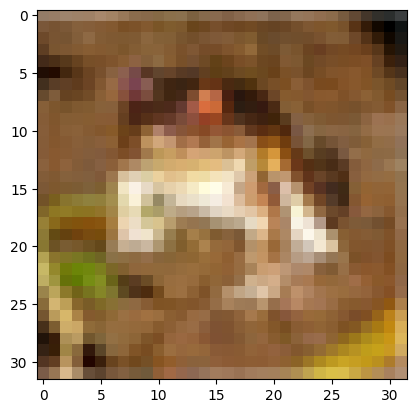

In [ ]:
show_example(train_images, train_labels, example_index = 0)

Label:  3


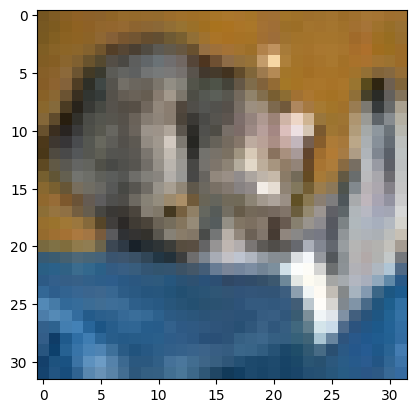

In [12]:
show_example(cv_images, cv_labels, example_index = 0)

## Building AlexNet

In 2012 a convolutional neural network called AlexNet won ImageNet competition. 

Go through an [original AlexNet paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to investigate the architecture. Next, investigate the [basics of Keras](https://keras.io/#keras-the-python-deep-learning-library). We will use it with TensorFlow backend.

You are also encouraged to go through some CNN tutorial for Keras. There is a number of them online (for example, [this](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) or [this](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)).
Now, build AlexNex network with Keras for object recognition. Note that standard AlexNet works with 224x224 input images. The dataset you are going to use for this problem is 32x32.

In [6]:
class AlexNetCifar10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCifar10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Training AlexNet

Use training set for training the network to recognize objects. You might want to use RMSProp optimizer to speed up the training.

Convolutional networks require a lot of computing power for training. Typical setup for training CNN is to use GPU, however, in this problem you are not required to do so. CPU will be fine as well.

If you are using CPU for this subproblem, training process might be slow. You can stop it manually as soon as you get meaningful results.

Report the results on the training and cross-validation sets. The report should contain the training logs.

In [4]:
class DatasetCifar10(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.tensor(label)

In [ ]:
DEVICE = torch.device('cuda')
batch_size = 64

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # normalization using CIFAR-10 stats
])

transform_cv= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
train_dataset = DatasetCifar10(train_images, train_labels, transform_train)
cv_dataset = DatasetCifar10(cv_images, cv_labels, transform_cv)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cv_dataloader = DataLoader(cv_dataset, batch_size=batch_size, shuffle=False)

In [17]:
num_epochs = 20
lr = 1e-3
model = AlexNetCifar10(num_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr)

train_losses, cv_losses = [], []
train_acc, cv_acc = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=True)
    
    for images, labels in progress_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        progress_bar.set_postfix(loss=f"Batch loss {train_loss / (total_train / labels.size(0)):.4f}", acc=f"{100 * correct_train / total_train:.2f}%")

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    cv_loss, correct_cv, total_cv = 0, 0, 0
    progress_bar = tqdm(cv_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Test", leave=True)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            cv_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_cv += (predicted == labels).sum().item()
            total_cv += labels.size(0)
            progress_bar.set_postfix(loss=f"Batch loss {cv_loss / (total_cv / labels.size(0)):.4f}", acc=f"{100 * correct_cv / total_cv:.2f}%")
            
    avg_val_loss = cv_loss / len(cv_dataloader)
    val_accuracy = 100 * correct_cv / total_cv
    cv_losses.append(avg_val_loss)
    cv_acc.append(val_accuracy)
    
    print(f"Average train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%")
    print(f"Average Test Loss: {avg_val_loss:.4f}, Test accuracy: {val_accuracy:.2f}%\n")



Epoch [1/20] Test: 100%|██████████| 157/157 [00:03<00:00, 51.08it/s, acc=33.98%, loss=Batch loss 0.4657]


Average train loss: 1350.3427, Train accuracy: 26.21%
Average Test Loss: 1.8540, Test accuracy: 33.98%



Epoch [2/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.02it/s, acc=46.98%, loss=Batch loss 0.3615]


Average train loss: 1.6533, Train accuracy: 39.83%
Average Test Loss: 1.4391, Test accuracy: 46.98%



Epoch [3/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.39it/s, acc=48.09%, loss=Batch loss 0.3547]


Average train loss: 1.4967, Train accuracy: 46.45%
Average Test Loss: 1.4119, Test accuracy: 48.09%



Epoch [4/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.62it/s, acc=56.16%, loss=Batch loss 0.3174]


Average train loss: 1.2800, Train accuracy: 54.50%
Average Test Loss: 1.2636, Test accuracy: 56.16%



Epoch [5/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.51it/s, acc=57.59%, loss=Batch loss 0.3009]


Average train loss: 1.1133, Train accuracy: 61.17%
Average Test Loss: 1.1978, Test accuracy: 57.59%



Epoch [6/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.71it/s, acc=54.13%, loss=Batch loss 0.3183]


Average train loss: 1.0087, Train accuracy: 65.22%
Average Test Loss: 1.2670, Test accuracy: 54.13%



Epoch [7/20] Test: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s, acc=63.93%, loss=Batch loss 0.2696]


Average train loss: 0.9346, Train accuracy: 67.76%
Average Test Loss: 1.0732, Test accuracy: 63.93%



Epoch [8/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.90it/s, acc=65.66%, loss=Batch loss 0.2618]


Average train loss: 0.8787, Train accuracy: 69.91%
Average Test Loss: 1.0421, Test accuracy: 65.66%



Epoch [9/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.06it/s, acc=64.90%, loss=Batch loss 0.2627]


Average train loss: 0.8295, Train accuracy: 71.62%
Average Test Loss: 1.0460, Test accuracy: 64.90%



Epoch [10/20] Test: 100%|██████████| 157/157 [00:03<00:00, 49.80it/s, acc=68.40%, loss=Batch loss 0.2277]


Average train loss: 0.8121, Train accuracy: 72.50%
Average Test Loss: 0.9065, Test accuracy: 68.40%



Epoch [11/20] Test: 100%|██████████| 157/157 [00:03<00:00, 49.97it/s, acc=71.79%, loss=Batch loss 0.2113]


Average train loss: 0.7835, Train accuracy: 73.65%
Average Test Loss: 0.8411, Test accuracy: 71.79%



Epoch [12/20] Test: 100%|██████████| 157/157 [00:03<00:00, 51.13it/s, acc=64.08%, loss=Batch loss 0.2874]


Average train loss: 0.7524, Train accuracy: 74.74%
Average Test Loss: 1.1440, Test accuracy: 64.08%



Epoch [13/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.30it/s, acc=71.73%, loss=Batch loss 0.2096]


Average train loss: 0.7389, Train accuracy: 75.00%
Average Test Loss: 0.8343, Test accuracy: 71.73%



Epoch [14/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.91it/s, acc=64.87%, loss=Batch loss 0.2756]


Average train loss: 0.7039, Train accuracy: 76.18%
Average Test Loss: 1.0972, Test accuracy: 64.87%



Epoch [15/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.26it/s, acc=70.86%, loss=Batch loss 0.2388]


Average train loss: 0.7036, Train accuracy: 76.62%
Average Test Loss: 0.9508, Test accuracy: 70.86%



Epoch [16/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.51it/s, acc=73.30%, loss=Batch loss 0.2009]


Average train loss: 0.7080, Train accuracy: 76.82%
Average Test Loss: 0.7998, Test accuracy: 73.30%



Epoch [17/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.15it/s, acc=71.39%, loss=Batch loss 0.2137]


Average train loss: 0.6901, Train accuracy: 77.14%
Average Test Loss: 0.8506, Test accuracy: 71.39%



Epoch [18/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.73it/s, acc=73.90%, loss=Batch loss 0.2053]


Average train loss: 0.6983, Train accuracy: 77.05%
Average Test Loss: 0.8174, Test accuracy: 73.90%



Epoch [19/20] Test: 100%|██████████| 157/157 [00:03<00:00, 49.06it/s, acc=69.08%, loss=Batch loss 0.2325]


Average train loss: 0.6678, Train accuracy: 77.93%
Average Test Loss: 0.9258, Test accuracy: 69.08%



Epoch [20/20] Test: 100%|██████████| 157/157 [00:03<00:00, 50.54it/s, acc=69.34%, loss=Batch loss 0.2348]

Average train loss: 0.8224, Train accuracy: 74.24%
Average Test Loss: 0.9345, Test accuracy: 69.34%



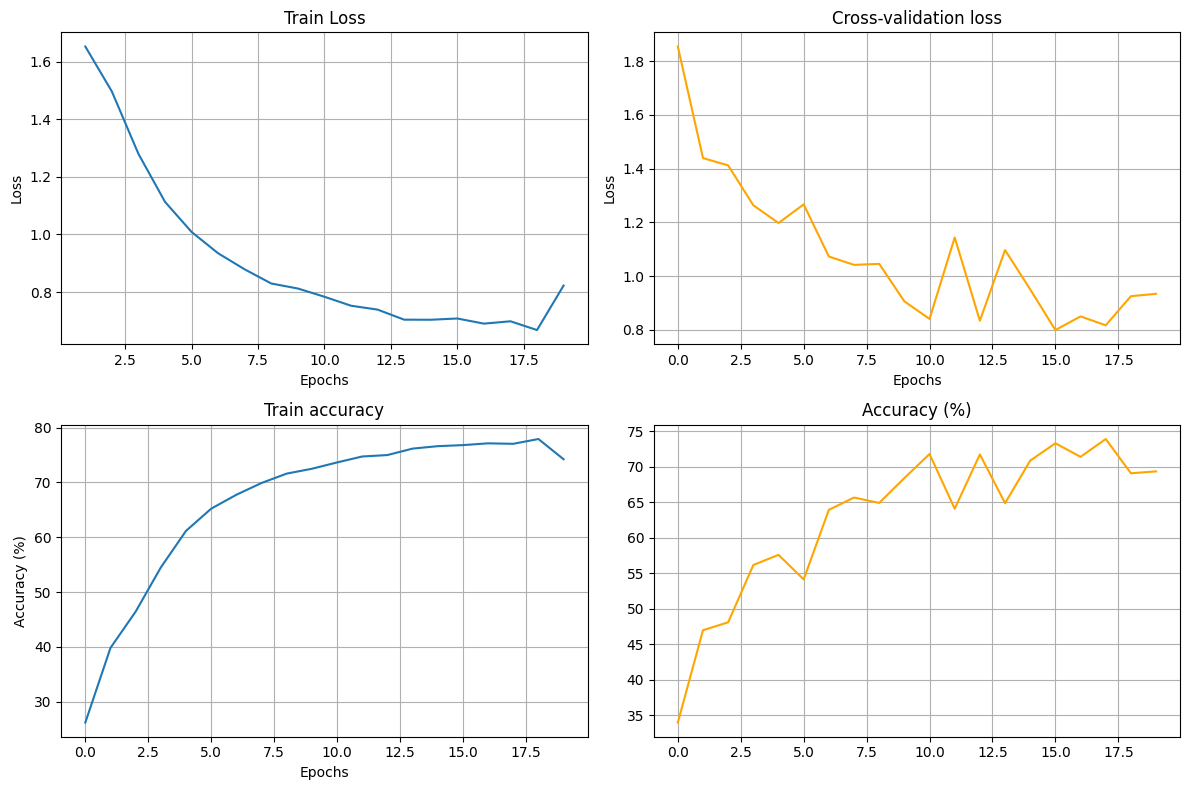

In [18]:
figure, axis = plt.subplots(2, 2, figsize=(12, 8))


axis[0, 0].plot(range(1, num_epochs), train_losses[1:]) # Skipping first element because it is too large (1000 loss) and corrupting plot
axis[0, 0].set_title("Train Loss")
axis[0, 0].set_xlabel("Epochs")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].grid(True)

axis[0, 1].plot(range(num_epochs), cv_losses, color='orange', label="Val Loss")
axis[0, 1].set_title("Cross-validation loss")
axis[0, 1].set_xlabel("Epochs")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].grid(True)

axis[1, 0].plot(range(num_epochs), train_acc)
axis[1, 0].set_title("Train accuracy")
axis[1, 0].set_xlabel("Epochs")
axis[1, 0].set_ylabel("Accuracy (%)")
axis[1, 0].grid(True)

axis[1, 1].plot(range(num_epochs), cv_acc, color='orange', label="Val Acc")
axis[1, 1].set_title("Cross-validation accuracy")
axis[1, 1].set_title("Epochs")
axis[1, 1].set_title("Accuracy (%)")
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [19]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model.eval()
cv_loss, correct_cv, total_cv = 0, 0, 0

class_correct = {class_name: 0 for class_name in classes}
class_total = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for images, labels in cv_dataloader:
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        cv_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_cv += (predicted == labels).sum().item()
        total_cv += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[classes[label]] += 1
            if label == pred:
                class_correct[classes[label]] += 1

avg_val_loss = cv_loss / len(cv_dataloader)
val_accuracy = 100 * correct_cv / total_cv
print(f"Accuracy test set by classes")
print(f'Total accuracy on test dataset: {100 * correct_cv / total_cv}')

for class_name in classes:
    accuracy = 100 * class_correct[class_name] / class_total[class_name]
    print(f" - {class_name}: {accuracy:.2f}%")

Accuracy test set by classes
Total accuracy on test dataset: 69.34
 - airplane: 86.70%
 - automobile: 87.90%
 - bird: 64.50%
 - cat: 41.80%
 - deer: 76.50%
 - dog: 43.50%
 - frog: 77.30%
 - horse: 56.80%
 - ship: 89.20%
 - truck: 69.20%


## Improving AlexNet

As you can see, AlexNet does not work very well on such a small dataset. Recall what you have learned from this class to improve its performance. You can also take a look at the [Dropout technique](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) and its [implementation in Keras](https://keras.io/layers/core/#dropout). 

Тут я буду пробувати як міняти саму модель та дані, так й інші можливі способи (оптимізатор, параметри, тощо) <br>
Я не використовую cross-validation ділячи трейн датасет, тому що підбір параметрів відрізнятиметься від архітектури моделі, так і від оптимізатора й підібрані параметри на одному, можуть бути гіршими на іншому (знаю, що це норм практика, не знімайте за це бали)

In [2]:
class AlexNetCifar10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCifar10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
class DatasetCifar10(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.tensor(label)

Трансформації, архітектуру та параметри підбирав вручну. Лишив найкращу версію, на мою думку

In [4]:
train_images, train_labels = pickle.load(open('data/train_set_all.pkl', 'rb'))
cv_images, cv_labels = pickle.load(open('data/test_set_all.pkl', 'rb'))

DEVICE = torch.device('cuda')
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # normalization using CIFAR-10 stats
])

transform_cv= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
train_dataset = DatasetCifar10(train_images, train_labels, transform_train)
cv_dataset = DatasetCifar10(cv_images, cv_labels, transform_cv)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cv_dataloader = DataLoader(cv_dataset, batch_size=batch_size, shuffle=False)

In [5]:
num_epochs = 25
lr = 1e-3
weight_decay = 0.006
momentum = 0.9

model = AlexNetCifar10(num_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_losses, cv_losses = [], []
train_acc, cv_acc = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=True)
    
    for images, labels in progress_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        progress_bar.set_postfix(loss=f"Batch loss {train_loss / (total_train / labels.size(0)):.4f}", acc=f"{100 * correct_train / total_train:.2f}%")

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    cv_loss, correct_cv, total_cv = 0, 0, 0
    progress_bar = tqdm(cv_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Test", leave=True)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            cv_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_cv += (predicted == labels).sum().item()
            total_cv += labels.size(0)
            progress_bar.set_postfix(loss=f"Batch loss {cv_loss / (total_cv / labels.size(0)):.4f}", acc=f"{100 * correct_cv / total_cv:.2f}%")
            
    avg_val_loss = cv_loss / len(cv_dataloader)
    val_accuracy = 100 * correct_cv / total_cv
    cv_losses.append(avg_val_loss)
    cv_acc.append(val_accuracy)
    
    print(f"Average train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%")
    print(f"Average test Loss: {avg_val_loss:.4f}, Test accuracy: {val_accuracy:.2f}%\n")


Epoch [1/25] Test: 100%|██████████| 157/157 [00:02<00:00, 52.65it/s, acc=57.12%, loss=Batch loss 0.3081]


Average train loss: 1.5950, Train accuracy: 41.52%
Average test Loss: 1.2265, Test accuracy: 57.12%



Epoch [2/25] Test: 100%|██████████| 157/157 [00:02<00:00, 53.76it/s, acc=64.25%, loss=Batch loss 0.2653]


Average train loss: 1.1073, Train accuracy: 61.84%
Average test Loss: 1.0561, Test accuracy: 64.25%



Epoch [3/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.49it/s, acc=71.21%, loss=Batch loss 0.2148]


Average train loss: 0.8874, Train accuracy: 69.98%
Average test Loss: 0.8553, Test accuracy: 71.21%



Epoch [4/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.03it/s, acc=75.38%, loss=Batch loss 0.1845]


Average train loss: 0.7535, Train accuracy: 74.84%
Average test Loss: 0.7344, Test accuracy: 75.38%



Epoch [5/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.15it/s, acc=78.10%, loss=Batch loss 0.1648]


Average train loss: 0.6784, Train accuracy: 77.52%
Average test Loss: 0.6561, Test accuracy: 78.10%



Epoch [6/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.39it/s, acc=78.74%, loss=Batch loss 0.1590]


Average train loss: 0.6045, Train accuracy: 79.85%
Average test Loss: 0.6329, Test accuracy: 78.74%



Epoch [7/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.14it/s, acc=79.97%, loss=Batch loss 0.1538]


Average train loss: 0.5435, Train accuracy: 81.89%
Average test Loss: 0.6124, Test accuracy: 79.97%



Epoch [8/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.88it/s, acc=81.47%, loss=Batch loss 0.1428]


Average train loss: 0.4971, Train accuracy: 83.37%
Average test Loss: 0.5685, Test accuracy: 81.47%



Epoch [9/25] Test: 100%|██████████| 157/157 [00:02<00:00, 55.05it/s, acc=81.96%, loss=Batch loss 0.1388]


Average train loss: 0.4561, Train accuracy: 84.77%
Average test Loss: 0.5527, Test accuracy: 81.96%



Epoch [10/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.47it/s, acc=82.97%, loss=Batch loss 0.1338]


Average train loss: 0.4290, Train accuracy: 85.84%
Average test Loss: 0.5328, Test accuracy: 82.97%



Epoch [11/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.54it/s, acc=82.94%, loss=Batch loss 0.1330]


Average train loss: 0.3876, Train accuracy: 87.03%
Average test Loss: 0.5295, Test accuracy: 82.94%



Epoch [12/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.89it/s, acc=82.57%, loss=Batch loss 0.1309]


Average train loss: 0.3623, Train accuracy: 87.88%
Average test Loss: 0.5213, Test accuracy: 82.57%



Epoch [13/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.91it/s, acc=81.17%, loss=Batch loss 0.1533]


Average train loss: 0.3306, Train accuracy: 88.90%
Average test Loss: 0.6103, Test accuracy: 81.17%



Epoch [14/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.77it/s, acc=83.46%, loss=Batch loss 0.1359]


Average train loss: 0.3097, Train accuracy: 89.70%
Average test Loss: 0.5412, Test accuracy: 83.46%



Epoch [15/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.97it/s, acc=83.58%, loss=Batch loss 0.1362]


Average train loss: 0.2904, Train accuracy: 90.29%
Average test Loss: 0.5421, Test accuracy: 83.58%



Epoch [16/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.12it/s, acc=83.57%, loss=Batch loss 0.1387]


Average train loss: 0.2749, Train accuracy: 90.91%
Average test Loss: 0.5521, Test accuracy: 83.57%



Epoch [17/25] Test: 100%|██████████| 157/157 [00:02<00:00, 53.08it/s, acc=84.51%, loss=Batch loss 0.1327]


Average train loss: 0.2538, Train accuracy: 91.54%
Average test Loss: 0.5283, Test accuracy: 84.51%



Epoch [18/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.90it/s, acc=84.25%, loss=Batch loss 0.1402]


Average train loss: 0.2376, Train accuracy: 92.25%
Average test Loss: 0.5582, Test accuracy: 84.25%



Epoch [19/25] Test: 100%|██████████| 157/157 [00:02<00:00, 55.56it/s, acc=84.90%, loss=Batch loss 0.1324]


Average train loss: 0.2209, Train accuracy: 92.66%
Average test Loss: 0.5272, Test accuracy: 84.90%



Epoch [20/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.28it/s, acc=84.43%, loss=Batch loss 0.1407]


Average train loss: 0.2054, Train accuracy: 93.29%
Average test Loss: 0.5603, Test accuracy: 84.43%



Epoch [21/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.34it/s, acc=82.56%, loss=Batch loss 0.1702]


Average train loss: 0.1880, Train accuracy: 93.75%
Average test Loss: 0.6775, Test accuracy: 82.56%



Epoch [22/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.68it/s, acc=84.77%, loss=Batch loss 0.1437]


Average train loss: 0.1842, Train accuracy: 94.02%
Average test Loss: 0.5719, Test accuracy: 84.77%



Epoch [23/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.03it/s, acc=84.91%, loss=Batch loss 0.1448]


Average train loss: 0.1815, Train accuracy: 94.14%
Average test Loss: 0.5766, Test accuracy: 84.91%



Epoch [24/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.87it/s, acc=84.79%, loss=Batch loss 0.1519]


Average train loss: 0.1642, Train accuracy: 94.65%
Average test Loss: 0.6048, Test accuracy: 84.79%



Epoch [25/25] Test: 100%|██████████| 157/157 [00:02<00:00, 54.33it/s, acc=84.55%, loss=Batch loss 0.1444]

Average train loss: 0.1547, Train accuracy: 94.84%
Average test Loss: 0.5749, Test accuracy: 84.55%



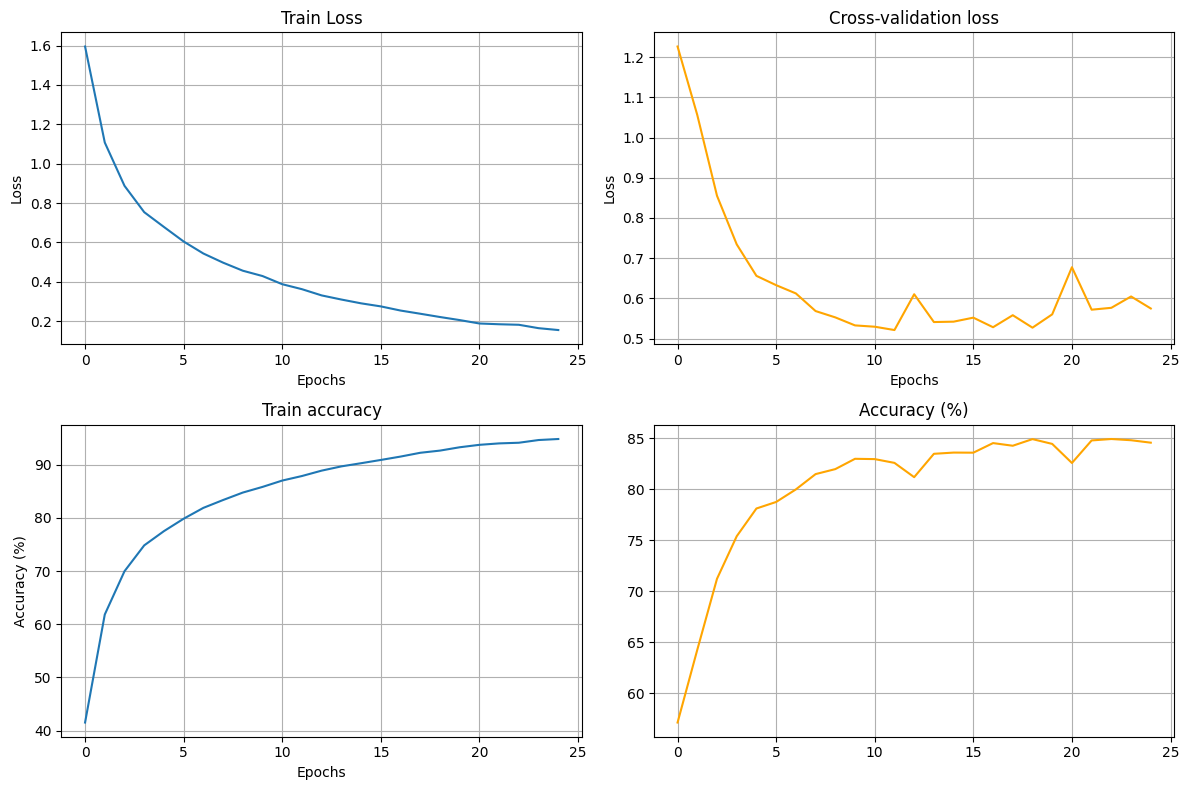

In [6]:
figure, axis = plt.subplots(2, 2, figsize=(12, 8))
axis[0, 0].plot(range(num_epochs), train_losses) # Skipping first element because it is too large (1000 loss) and corrupting plot
axis[0, 0].set_title("Train Loss")
axis[0, 0].set_xlabel("Epochs")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].grid(True)

axis[0, 1].plot(range(num_epochs), cv_losses, color='orange', label="Val Loss")
axis[0, 1].set_title("Cross-validation loss")
axis[0, 1].set_xlabel("Epochs")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].grid(True)

axis[1, 0].plot(range(num_epochs), train_acc)
axis[1, 0].set_title("Train accuracy")
axis[1, 0].set_xlabel("Epochs")
axis[1, 0].set_ylabel("Accuracy (%)")
axis[1, 0].grid(True)

axis[1, 1].plot(range(num_epochs), cv_acc, color='orange', label="Val Acc")
axis[1, 1].set_title("Cross-validation accuracy")
axis[1, 1].set_title("Epochs")
axis[1, 1].set_title("Accuracy (%)")
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model.eval()
cv_loss, correct_cv, total_cv = 0, 0, 0

class_correct = {class_name: 0 for class_name in classes}
class_total = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for images, labels in cv_dataloader:
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        cv_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_cv += (predicted == labels).sum().item()
        total_cv += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[classes[label]] += 1
            if label == pred:
                class_correct[classes[label]] += 1

avg_val_loss = cv_loss / len(cv_dataloader)
val_accuracy = 100 * correct_cv / total_cv
print(f"Accuracy test set by classes")
print(f'Total accuracy on test dataset: {100 * correct_cv / total_cv}%')

for class_name in classes:
    accuracy = 100 * class_correct[class_name] / class_total[class_name]
    print(f" - {class_name}: {accuracy:.2f}%")

Accuracy test set by classes
Total accuracy on test dataset: 84.55%
 - airplane: 82.50%
 - automobile: 93.40%
 - bird: 80.30%
 - cat: 69.50%
 - deer: 83.80%
 - dog: 83.30%
 - frog: 85.80%
 - horse: 85.40%
 - ship: 92.30%
 - truck: 89.20%


Найкраща точніть була була на 23 епоці - 84.91%, трохи і іншими параметрами виходило 85% з чимось, але я її поміняв <br>
Загалом після 20 епоку приріст вже мізерний, і починається overfit моделі